## Code source du modèle

### Avertissement

⚠️ **Veuillez effectuer l'étape de configuration avec soin**

Il est essentiel de compléter l'étape de configuration correctement pour éviter toute erreur. Veuillez vous assurer de respecter les points suivants :

- **Avant tout push vers GitHub,** assurez-vous de ne pas laisser d'informations sensibles ou compromettantes dans votre code.
- **Le dépôt doit être cloné dans le bon répertoire sur Google Drive** pour garantir que les fichiers sont correctement synchronisés.
- **Git doit être correctement configuré** avant d'effectuer toute action sur le dépôt, telles que `git add`, `git commit`, etc.

---

⚠️ **Ne jamais exposer votre `GITHUB_TOKEN`**.

Il est impératif que votre `GITHUB_TOKEN` soit gardé secret. Ne le partagez **jamais** dans des dépôts publics, des fichiers non sécurisés ou des endroits où des tiers pourraient y accéder. Toute fuite de votre token pourrait entraîner des accès non autorisés à vos projets et à vos données privées.

---

### Conseil : Utilisation de `!bash -c` pour les commandes Linux dans Google Colab

Lorsque vous exécutez des commandes Linux dans Google Colab, il est recommandé d'utiliser `!bash -c` pour enchaîner plusieurs commandes dans un même environnement. Cela vous permet de garder toutes les commandes dans un même contexte de shell. Par exemple, si vous voulez changer de répertoire et exécuter plusieurs commandes, vous pouvez utiliser la commande suivante :

```bash
!bash -c "cd /content/drive/MyDrive/SAE_S5 && git status"
```

### Explication du bloc "Conseil" :

- **Utilisation de `!bash -c`** : Quand tu souhaites enchaîner plusieurs commandes dans Google Colab dans un même shell (par exemple, changer de répertoire avec `cd` puis exécuter d'autres commandes comme `git status`), tu peux utiliser `!bash -c`. Cela te permet d'éviter de devoir ouvrir plusieurs cellules ou d'essayer de combiner les commandes de manière incorrecte.
  
- **Syntaxe** : La commande `!bash -c "commandes"` permet d'exécuter plusieurs commandes Linux dans un même contexte, ce qui garantit qu'elles seront exécutées les unes après les autres dans le même environnement de shell.

Cela permet une meilleure gestion des environnements de travail et d'éviter des erreurs comme celle de ne pas pouvoir exécuter des commandes successivement dans différentes cellules.

# 1 . Connexion avec le drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2 . Installer la configuration

In [ ]:
# Attendre quelque secondes avant de continuer (sync avec le drive)
!mkdir -p /content/drive/MyDrive/SAE_S5

In [ ]:
bash_script = """
#!/bin/bash

#####################
#                   #
#       Config      #
#                   #
#####################

apt-get install git

if [ "$#" -ne 3 ]; then
    echo "Usage: $0 <TOKEN> <GITHUB_USER> <GITHUB_EMAIL>"
    exit 1
fi

TOKEN=$1
GITHUB_USER=$2
GITHUB_EMAIL=$3

REPO_DIR="/content/drive/MyDrive/SAE_S5"

if [ -d "$REPO_DIR" ]; then
  echo "Le dossier existe déjà. Suppression du dossier existant..."
  rm -rf "$REPO_DIR"
fi

mkdir -p "$REPO_DIR"

git clone https://$TOKEN@github.com/JagoOgaj/SAE_S5.git "$REPO_DIR"

cd "$REPO_DIR"

git config --global user.name "$GITHUB_USER"
git config --global user.email "$GITHUB_EMAIL"

git remote set-url origin https://$TOKEN@github.com/JagoOgaj/SAE_S5.git

pip install -r "$REPO_DIR/requirements.txt"

echo "Configuration terminée avec succès!"
"""

with open('/content/drive/MyDrive/SAE_S5/config.sh', 'w') as f:
    f.write(bash_script)

print("Le fichier config.sh a été créé avec succès!")

Le fichier config.sh a été créé avec succès!


In [ ]:
!chmod +x /content/drive/MyDrive/SAE_S5/config.sh

In [ ]:
#!bash /content/drive/MyDrive/SAE_S5/config.sh <Token> <User Github> <Email Github>

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Le dossier existe déjà. Suppression du dossier existant...
Cloning into '/content/drive/MyDrive/SAE_S5'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 56 (delta 20), reused 48 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 90.92 KiB | 3.64 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Configuration terminée avec succès!


## Git Command

In [ ]:
#Use here git command
bash_script = """
#!/bin/bash

#####################
#                   #
#    Git Command    #
#                   #
#####################

REPO_DIR="/content/drive/MyDrive/SAE_S5"

cd "$REPO_DIR"

# Add comand here #

"""

with open('/content/drive/MyDrive/SAE_S5/git.sh', 'w') as f:
    f.write(bash_script)


!chmod +x /content/drive/MyDrive/SAE_S5/git.sh

!bash /content/drive/MyDrive/SAE_S5/git.sh

On branch samy
Untracked files:
  (use "git add <file>..." to include in what will be committed)
	git.sh

nothing added to commit but untracked files present (use "git add" to track)


## Model gender detection Code Source

## 1. Make labels


In [ ]:
#Imports
import zipfile
import cv2
import numpy as np

In [ ]:
#Labels

path_zipFile: str = "/content/drive/MyDrive/SAE_S5/UTKFace.zip"

folder: str = "UTKFace/"

pixels: list = []
gender : list = []

with zipfile.ZipFile(path_zipFile, "r") as z :
  for imgName in z.namelist():
    if imgName.startswith(folder) and imgName.endswith(".jpg") :
      genders = int(imgName.split("_")[1])

      with z.open(imgName) as imgFile :
        img = np.frombuffer(imgFile.read(), np.uint8)
        img = cv2.imdecode(img, cv2.IMREAD_COLOR)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (100, 100))

        pixels.append(np.array(img))
        gender.append(np.array(genders))


In [ ]:
# Optimize labels with numpy

pixels = np.array(pixels) / 255
gender = np.array(gender, np.uint64)

In [ ]:
# Shape

print(f"Le nombre d'image -> {len(pixels)}\n")
print(f"Le nombre de genre associés aux images -> {len(gender)}\n")
print(f"Shape de pixels -> {pixels.shape}\n")
print(f"Shape de gender -> {gender.shape}")


Le nombre d'image -> 23708

Le nombre de genre associés aux images -> 23708

Shape de pixels -> (23708, 100, 100)

Shape de gender -> (23708,)


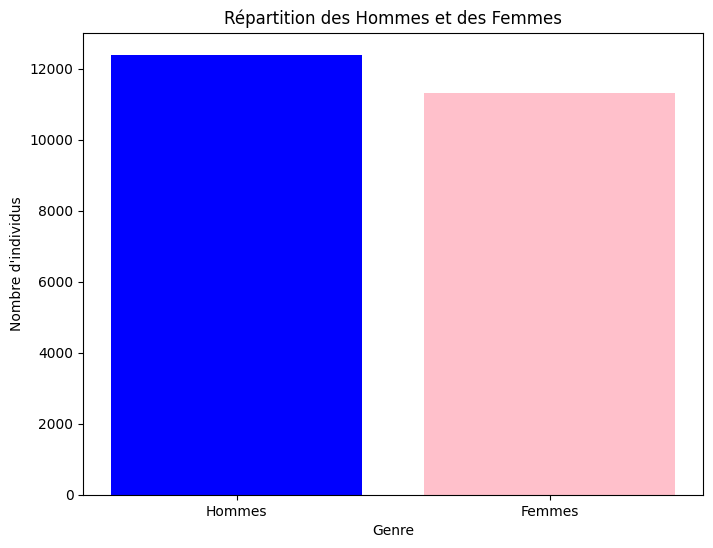

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Comptage des hommes (0) et des femmes (1)
hommes = np.sum(gender == 0)  # Nombre d'hommes (label 0)
femmes = np.sum(gender == 1)  # Nombre de femmes (label 1)

# Préparer les données pour l'affichage
labels = ['Hommes', 'Femmes']
counts = [hommes, femmes]

# Création du graphique à barres
plt.figure(figsize=(8,6))
plt.bar(labels, counts, color=['blue', 'pink'])

# Ajouter des titres et labels
plt.title("Répartition des Hommes et des Femmes")
plt.xlabel("Genre")
plt.ylabel("Nombre d'individus")
plt.show()

## 2. Make X_train , X_test, y_train and y_test

In [ ]:
# Imports
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pixels, gender, random_state = 93)

In [ ]:
print(f"Nombre d'echantillons données en entrée pour l'entrainement -> {len(X_train)}\n")
print(f"Nombre d'échantillins données en entreé pour les test -> {len(X_test)}\n")
print(f"Nombre de label associés au enchantillons d'entrainement -> {len(y_train)}\n")
print(f"Nombre de label associés au enchantillons de test -> {len(y_test)}")

Nombre d'echantillons données en entrée pour l'entrainement -> 17781

Nombre d'échantillins données en entreé pour les test -> 5927

Nombre de label associés au enchantillons d'entrainement -> 17781

Nombre de label associés au enchantillons de test -> 5927


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

datagen = ImageDataGenerator(
  rotation_range=10,
  width_shift_range=0.1,
  height_shift_range=0.1,
  zoom_range=0.1,
  horizontal_flip=True
)

datagen.fit(X_train)

## Model architecture

## 1. Architecture

In [ ]:
# Imports
import tensorflow as tf

from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, AvgPool2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten, Input
from tensorflow.keras.layers import Input, Activation, Add
from tensorflow.keras.regularizers  import l2

In [ ]:
"""
    Explication CNN

    Couches convolutionnelles (Conv2D) : Ces couches sont responsables de l’extraction des caractéristiques locales à partir des images. Elles augmentent progressivement la complexité des motifs appris, avec des filtres de plus en plus nombreux.

    MaxPooling2D : Réduit les dimensions des images tout en conservant les informations essentielles.

    Dropout : Utilisé pour régulariser le modèle et éviter le sur-apprentissage.

    Dense : Couches entièrement connectées qui permettent au modèle d’apprendre des relations complexes entre les caractéristiques extraites par les couches convolutionnelles.

    Sigmoid en sortie : Cela indique qu’il s’agit probablement d’une tâche de classification binaire (dans notre cas homme/femme).

"""


input = Input(shape = (100, 100, 1))

conv1 = Conv2D(32, (3,3), padding = 'same', strides = (1, 1), kernel_regularizer = l2(0.001))(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size = (2,2))(conv1)

conv2 = Conv2D(64, (3,3), padding = 'same', strides = (1, 1), kernel_regularizer = l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size = (2,2))(conv2)

conv3 = Conv2D(128, (3,3), padding = 'same', strides = (1, 1), kernel_regularizer = l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size = (2,2))(conv3)

conv4 = Conv2D(256, (3,3), padding = 'same', strides = (1, 1), kernel_regularizer = l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size = (2,2))(conv4)

flatten = Flatten()(pool4)

dense1 = Dense(128, activation = 'relu')(flatten)
drop1 = Dropout(0.2)(dense1)
output = Dense(2, activation = 'sigmoid')(drop1)

In [ ]:
# Compile model

model = Model(inputs = input, outputs = output)
model.compile(optimizer = 'adam', loss = ["sparse_categorical_crossentropy"], metrics = ['accuracy'])


In [ ]:
#Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100, 100, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 100, 100, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 1,567,874 (5.98 MB)

 Trainable params: 1,567,874 (5.98 MB)

 Non-trainable params: 0 (0.00 B)

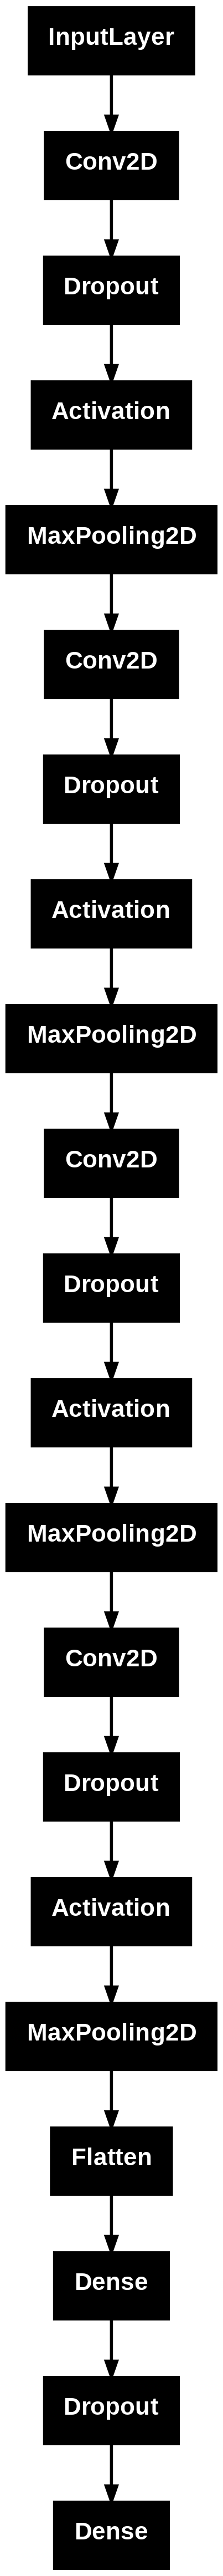

In [ ]:
#Plot model

from tensorflow.keras.utils import plot_model
plot_model(model)

## 2. Save model

In [ ]:
# Imports
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
#Save

model_path: str = "/content/drive/MyDrive/SAE_S5/model/sae_model_gender_detection.keras"

checkpoint = ModelCheckpoint(
    model_path,                   # Le chemin où le modèle sera sauvegardé
    monitor='loss',               # La métrique à surveiller pendant l'entraînement
    verbose=1,                    # Afficher des messages lors de l'enregistrement du modèle
    save_best_only=True,          # Ne sauvegarder que le meilleur modèle selon la métrique
    save_weights_only=False,      # Sauvegarder à la fois les poids et la structure du modèle
    mode='auto',                  # Choisir le mode d'évaluation (auto, min, max)
    save_freq='epoch'             # Fréquence d'enregistrement du modèle (ici à la fin de chaque époque)
)

early_stopping = EarlyStopping(
      monitor='val_loss',   # Surveillez plutôt la perte pour éviter overfitting
      patience=15,           # Plus de patience avant d'arrêter l'entraînement
      restore_best_weights=True
)


callback_list = [checkpoint, early_stopping]


## Training

## 1. Train model

In [ ]:
# Train with the GPU

with tf.device('/GPU:0'):
  save = model.fit(
      datagen.flow(X_train, y_train, batch_size=64),
      validation_data=(X_test, y_test),
      epochs=100,
      class_weight={0: 1., 1: 1.1},
      callbacks=callback_list
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6134 - loss: 0.7838
Epoch 1: loss improved from inf to 0.68574, saving model to /content/drive/MyDrive/SAE_S5/model/sae_model_gender_detection.keras
278/278 ━━━━━━━━━━━━━━━━━━━━ 36s 106ms/step - accuracy: 0.6139 - loss: 0.7831 - val_accuracy: 0.7618 - val_loss: 0.5499
Epoch 2/100
277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7619 - loss: 0.5511
Epoch 2: loss improved from 0.68574 to 0.51542, saving model to /content/drive/MyDrive/SAE_S5/model/sae_model_gender_detection.keras
278/278 ━━━━━━━━━━━━━━━━━━━━ 22s 78ms/step - accuracy: 0.7620 - loss: 0.5509 - val_accuracy: 0.8274 - val_loss: 0.4252
Epoch 3/100
277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8150 - loss: 0.4587
Epoch 3: loss improved from 0.51542 to 0.45655, saving model to /content/drive/MyDrive/SAE_S5/model/sae_model_gender_detection.keras
278/278 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - accuracy: 0.8150 - loss: 0.4586 - val_accuracy: 0.8401 - val_loss: 0.

## Validation

## 1. Graph

In [ ]:
# Imports
import matplotlib.pyplot as plt

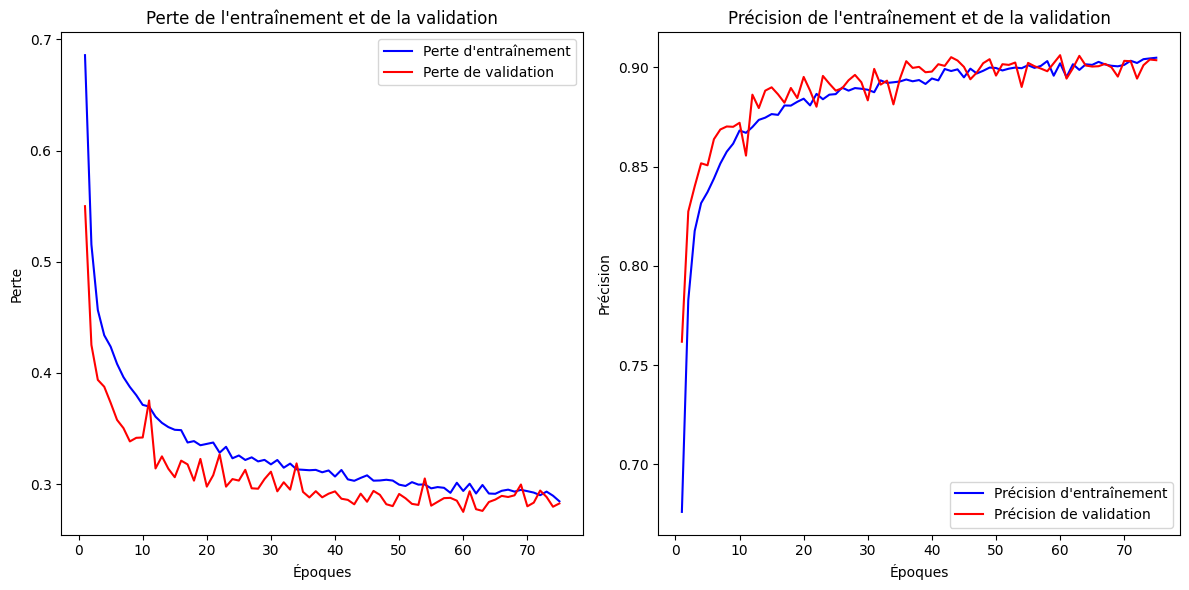

In [ ]:
# Extraire les métriques depuis 'save.history'
epochs = range(1, len(save.history['loss']) + 1)
train_loss = save.history['loss']
val_loss = save.history['val_loss']
train_accuracy = save.history['accuracy']
val_accuracy = save.history['val_accuracy']

# Créer des sous-graphiques (2 graphiques : perte et précision)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Premier graphique : Perte (Loss)
ax1.plot(epochs, train_loss, label='Perte d\'entraînement', color='blue')
ax1.plot(epochs, val_loss, label='Perte de validation', color='red')
ax1.set_title('Perte de l\'entraînement et de la validation')
ax1.set_xlabel('Époques')
ax1.set_ylabel('Perte')
ax1.legend()

# Deuxième graphique : Précision (Accuracy)
ax2.plot(epochs, train_accuracy, label='Précision d\'entraînement', color='blue')
ax2.plot(epochs, val_accuracy, label='Précision de validation', color='red')
ax2.set_title('Précision de l\'entraînement et de la validation')
ax2.set_xlabel('Époques')
ax2.set_ylabel('Précision')
ax2.legend()

# Afficher les graphiques
plt.tight_layout()  # Ajuste la mise en page pour éviter que les éléments se chevauchent
plt.show()

## 2. Evaluate

In [ ]:
# Imports
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)

print(f'Perte sur les données de test : {loss}')
print(f'Précision sur les données de test : {accuracy}')

186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9034 - loss: 0.2782
Perte sur les données de test : 0.2750149667263031
Précision sur les données de test : 0.9061920046806335


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy : 0.91
Precision : 0.89
Recall : 0.918722
F1-score : 0.90


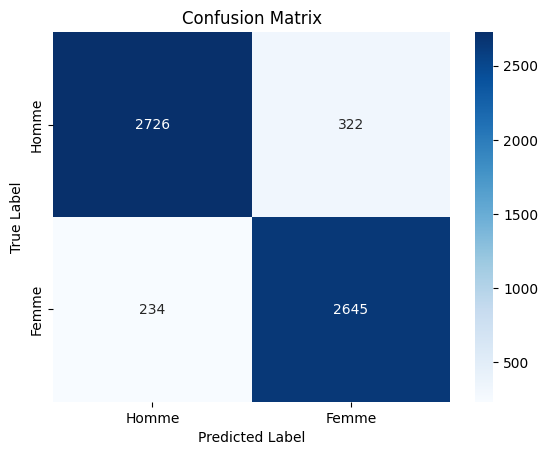

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy : {accuracy:.2f}")
print(f"Precision : {precision:.2f}")
print(f"Recall : {recall:2f}")
print(f"F1-score : {f1:.2f}")

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Homme', 'Femme'], yticklabels=['Homme', 'Femme'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## Test

In [ ]:
# Import
from PIL import Image

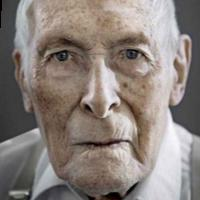

In [ ]:
img_test_path: str = "/content/drive/MyDrive/SAE_S5/110_0_0_20170112213500903.jpg.chip.jpg"
#img_test_path : str = "/content/drive/MyDrive/SAE_S5/110_0_0_20170112213500903.jpg.chip.jpg"
Image.open(img_test_path)

In [ ]:
#Load image

img = cv2.imread(img_test_path, cv2.IMREAD_COLOR)

# Convertir en niveaux de gris
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Redimensionner à (100, 100)
img = cv2.resize(img, (100, 100))

# Normaliser les pixels dans la plage [0, 1]
img = img / 255.0

# Ajouter une dimension supplémentaire pour simuler un lot (lot de 1 image)
img = np.expand_dims(img, axis=0)  # (1, 100, 100)
img = np.expand_dims(img, axis=-1)


In [ ]:
prediction = model.predict(img)

print(prediction)

result = np.argmax(prediction)

if result == 0 :
  print("Homme")
elif result == 1 :
  print("Femme")
else :
  print("Inconnu")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
[[0.78979534 0.17855456]]
Homme


In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
img = cv2.imread(img_test_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

if len(faces) > 0:

  (x, y, w, h) = faces[0]

  face_img = img[y:y+h, x:x+w]

  face_img = cv2.resize(face_img, (100, 100))

  face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)

  test_pixels = [np.array(face_img)]

  new_test_pixels = np.array(test_pixels)

  face_img_pil = Image.fromarray(face_img)

  prediction = model.predict(new_test_pixels)
  print(prediction)

  result = np.argmax(prediction)

  if result == 0 :
    print("Homme")
  elif result == 1 :
    print("Femme")
  else :
    print("Inconnu")

## Model age detection

## 1. Make Labels

In [1]:
# Imports
import zipfile
import cv2
import numpy as np

In [3]:
# Load UTKFace dataset

path_zipFile: str = "/content/drive/MyDrive/SAE_S5/UTKFace.zip"

folder: str = "UTKFace/"

pixels = []
age_labels : list = []

with zipfile.ZipFile(path_zipFile, "r") as z :
  for imgName in z.namelist():
    if imgName.startswith(folder) and imgName.endswith(".jpg") :
      ages = int((imgName.split("_")[0]).split("/")[1])
      with z.open(imgName) as imgFile:
        img = np.frombuffer(imgFile.read(), np.uint8)
        img = cv2.imdecode(img, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (128, 128))
        pixels.append(np.array(img))
        age_labels.append(np.array(ages))


In [4]:
pixels = np.array(pixels) / 255.0
age_labels = np.array(age_labels, np.uint64)

In [ ]:
# Shape

print(f"Le nombre d'image -> {len(pixels)}\n")
print(f"Le nombre d'age associés aux images -> {len(age_labels)}\n")
print(f"Shape de pixels -> {pixels.shape}\n")
print(f"Shape de age -> {age_labels.shape}")


Le nombre d'image -> 23708

Le nombre d'age associés aux images -> 23708

Shape de pixels -> (23708, 128, 128)

Shape de age -> (23708,)


Ages : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116]
Nombre d'image par age : [1123, 482, 289, 273, 196, 131, 139, 263, 166, 156, 65, 130, 81, 157, 177, 247, 158, 262, 98, 284, 346, 395, 426, 859, 734, 2197, 615, 918, 570, 724, 350, 664, 143, 409, 880, 483, 293, 325, 266, 526, 132, 266, 157, 100, 440, 153, 170, 153, 148, 381, 138, 232, 241, 353, 268, 236, 97, 271, 82, 293, 161, 125, 103, 50, 259, 77, 94, 100, 56, 147, 33, 98, 63, 32, 148, 58, 28, 69, 23, 133, 22, 40, 18, 24, 155, 35, 10, 34, 33, 82, 2, 13, 5, 0, 9, 17, 0, 0, 9, 11, 2, 0, 1, 0, 5, 0, 0, 0, 0, 5, 1, 0,

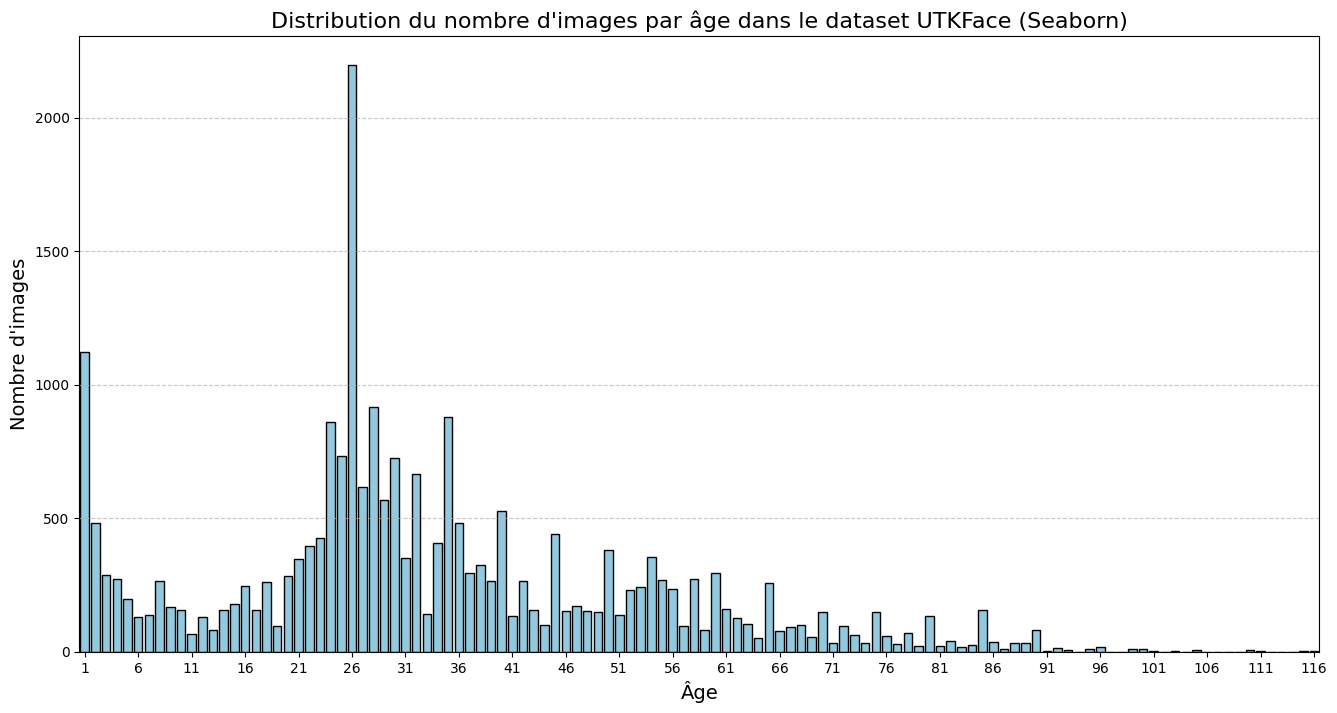

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

age_distribution = {age: 0 for age in range(1, 117)}

for age in age_labels:
  if age in age_distribution:
      age_distribution[age] += 1


ages = list(age_distribution.keys())
counts = list(age_distribution.values())

print(f"Ages : {ages}")
print(f"Nombre d'image par age : {counts}")


plt.figure(figsize=(16, 8))
sns.barplot(x=ages, y=counts, color='skyblue', edgecolor='black')
plt.xlabel('Âge', fontsize=14)
plt.ylabel('Nombre d\'images', fontsize=14)
plt.title('Distribution du nombre d\'images par âge dans le dataset UTKFace (Seaborn)', fontsize=16)
plt.xticks(range(0, 117, 5))  # Graduation tous les 5 ans
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 2 . Preprocessing

In [5]:
# Imports
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(pixels, age_labels, random_state = 93)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Normaliser les étiquettes d'entraînement
y_train_normalized = scaler.fit_transform(y_train.reshape(-1, 1))

# Normaliser les étiquettes de test (en utilisant uniquement la transformation, pas fit_transform)
y_test_normalized = scaler.transform(y_test.reshape(-1, 1))


## 3 . Architecture

In [9]:
# Imports
import tensorflow as tf

from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, AvgPool2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten, Input
from tensorflow.keras.layers import Input, Activation, Add
from tensorflow.keras.regularizers  import l2
from keras.optimizers import Adam

In [10]:

#X_train = X_train / 255.0
#X_test = X_test / 255.0


inputs = Input(shape=(128, 128, 1))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flat = Flatten()(maxp_4)
dense_1 = Dense(128, activation='relu')(flat)
dropout = Dropout(0.4)(dense_1)
output = Dense(1, activation='linear')(dropout)

model = Model(inputs=[inputs], outputs=[output])


In [11]:
# Compile model

model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

In [ ]:
# Summary

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,567,745 (5.98 MB)

 Trainable params: 1,567,745 (5.98 MB)

 Non-trainable params: 0 (0.00 B)

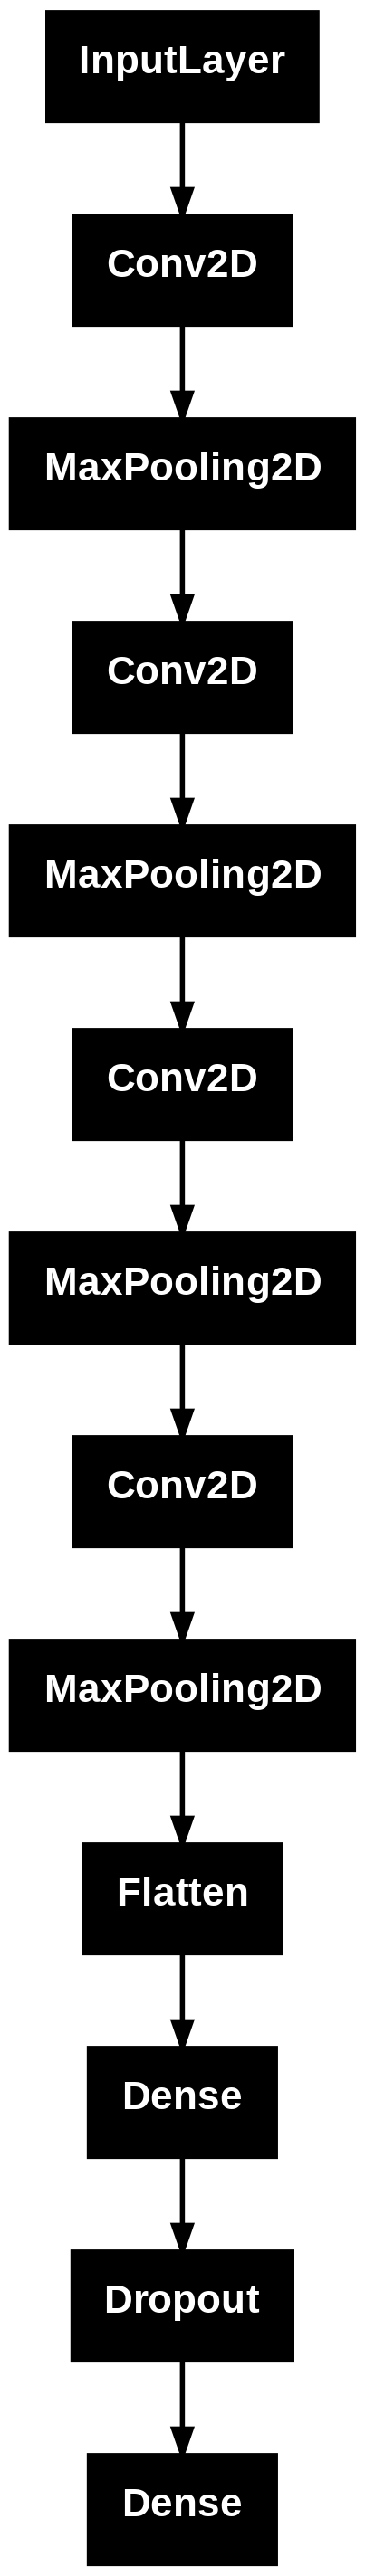

In [ ]:
# Plot model

from tensorflow.keras.utils import plot_model
plot_model(model)

## 4 . Train model

In [13]:
# Save model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
model_path: str = "/content/drive/MyDrive/SAE_S5/model/sae_model_age_prediction2.keras"

checkpoint = ModelCheckpoint(
    model_path,                   # Le chemin où le modèle sera sauvegardé
    monitor='loss',               # La métrique à surveiller pendant l'entraînement
    verbose=1,                    # Afficher des messages lors de l'enregistrement du modèle
    save_best_only=True,          # Ne sauvegarder que le meilleur modèle selon la métrique
    save_weights_only=False,      # Sauvegarder à la fois les poids et la structure du modèle
    mode='auto',                  # Choisir le mode d'évaluation (auto, min, max)
    save_freq='epoch'             # Fréquence d'enregistrement du modèle (ici à la fin de chaque époque)
)

early_stopping = EarlyStopping(
  monitor='val_loss',
  patience=10,
  restore_best_weights=True,
  verbose=1
)


callback_list = [checkpoint, early_stopping]

In [14]:
history = model.fit(
  datagen.flow(X_train, y_train_normalized, batch_size=64),
  validation_data=(X_test, y_test_normalized),
  epochs=100,
  callbacks=callback_list
)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.1651 - mae: 0.1651
Epoch 1: loss improved from inf to 0.13617, saving model to /content/drive/MyDrive/SAE_S5/model/sae_model_age_prediction2.keras
278/278 ━━━━━━━━━━━━━━━━━━━━ 49s 145ms/step - loss: 0.1649 - mae: 0.1649 - val_loss: 0.1318 - val_mae: 0.1318
Epoch 2/100
277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1166 - mae: 0.1166
Epoch 2: loss improved from 0.13617 to 0.11201, saving model to /content/drive/MyDrive/SAE_S5/model/sae_model_age_prediction2.keras
278/278 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.1165 - mae: 0.1165 - val_loss: 0.0977 - val_mae: 0.0977
Epoch 3/100
277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1059 - mae: 0.1059
Epoch 3: loss improved from 0.11201 to 0.10382, saving model to /content/drive/MyDrive/SAE_S5/model/sae_model_age_prediction2.keras
278/278 ━━━━━━━━━━━━━━━━━━━━ 30s 105ms/step - loss: 0.1059 - mae: 0.1059 - val_loss: 0.0882 - val_mae: 0.0882
Epoch 4/100
277/278 ━━━━━━━━━━━━━━━━━━

## 5. Evaluate

In [15]:
import matplotlib.pyplot as plt

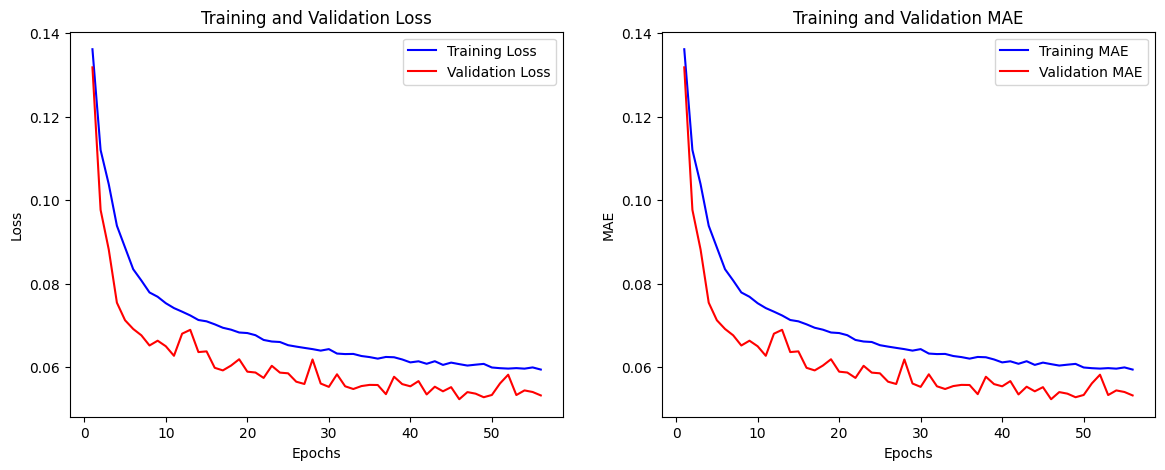

In [16]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Créer les graphiques
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(14, 5))

# Graphique de la loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Graphique du MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, train_mae, 'b-', label='Training MAE')
plt.plot(epochs, val_mae, 'r-', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

In [18]:
test_loss, test_mae = model.evaluate(X_test, y_test_normalized, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test Loss: 0.0523
Test MAE: 0.0523


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Supposons que vous avez déjà un modèle entraîné et que vous avez fait des prédictions
y_pred_normalized = model.predict(X_test)  # Prédictions normalisées

# Inverser la normalisation des prédictions
y_pred = scaler.inverse_transform(y_pred_normalized)

# Calculer les métriques sur les prédictions inversées
mae = mean_absolute_error(y_test, y_pred)  # MAE sur les valeurs originales
mse = mean_squared_error(y_test, y_pred)  # MSE sur les valeurs originales
rmse = np.sqrt(mse)  # RMSE = racine carrée du MSE
r2 = r2_score(y_test, y_pred)  # R² (coefficient de détermination)

# Afficher les résultats
print(f"MAE (réel) : {mae}")
print(f"MSE (réel) : {mse}")
print(f"RMSE (réel) : {rmse}")
print(f"R² (réel) : {r2}")

186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
MAE (réel) : 6.011447870082209
MSE (réel) : 70.25364086470285
RMSE (réel) : 8.381744500084864
R² (réel) : 0.8212011456489563


In [ ]:
# Load model
import tensorflow as tf

path = "/content/drive/MyDrive/SAE_S5/model/sae_model_age_prediction2.keras"

model = tf.keras.models.load_model(path)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,703,237 (17.94 MB)

 Trainable params: 1,567,745 (5.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,135,492 (11.96 MB)

In [ ]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test Loss: 5.7140
Test MAE: 5.7140


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
y_test shape: (5927,)
y_pred shape: (5927,)
errors shape: (5927,)


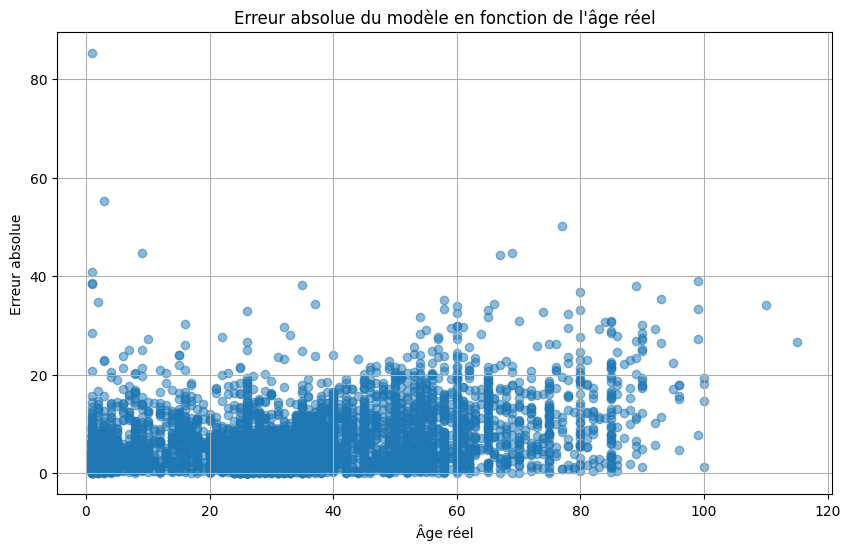

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Prédictions sur les données de test
y_pred_normalized = model.predict(X_test)  # Prédictions normalisées

# Inverser la normalisation des prédictions
y_pred = scaler.inverse_transform(y_pred_normalized)

# Aplatir y_pred pour correspondre à la forme de y_test
y_pred = y_pred.flatten()

# Vérification des tailles
print(f"y_test shape: {y_test.shape}")
print(f"y_pred shape: {y_pred.shape}")

# Calcul de l'erreur absolue
errors = np.abs(y_pred - y_test)

# Vérification des tailles des erreurs
print(f"errors shape: {errors.shape}")

# Tracer l'erreur en fonction des âges réels
plt.figure(figsize=(10, 6))
plt.scatter(y_test, errors, alpha=0.5)
plt.title("Erreur absolue du modèle en fonction de l'âge réel")
plt.xlabel("Âge réel")
plt.ylabel("Erreur absolue")
plt.grid(True)
plt.show()


In [21]:
from PIL import Image

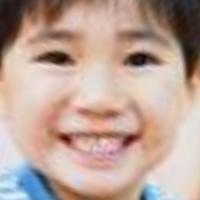

In [26]:
from os import pathconf
path = "/content/drive/MyDrive/SAE_S5/7_0_2_20161219190327212.jpg.chip.jpg"

Image.open(path)

In [27]:
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)


image = cv2.resize(image, (128, 128))


image = image / 255.0


image = np.expand_dims(image, axis=0)
image = np.expand_dims(image, axis=-1)
print(image.shape)
predicted_age_normalized = model.predict(image)

# Inverser la normalisation des prédictions
predicted_age = scaler.inverse_transform(predicted_age_normalized)

# Afficher le résultat
print(f"L'âge prédit est: {predicted_age[0][0]:.2f} ans")

(1, 128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
L'âge prédit est: 9.89 ans


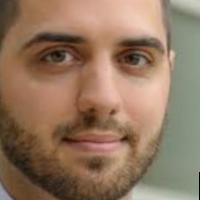

In [40]:
from os import pathconf
path2 = "/content/drive/MyDrive/SAE_S5/40_0_0_20170116235455068.jpg.chip.jpg"

Image.open(path2)

In [41]:
image = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)


image = cv2.resize(image, (128, 128))


image = image / 255.0


image = np.expand_dims(image, axis=0)
image = np.expand_dims(image, axis=-1)
print(image.shape)
predicted_age_normalized = model.predict(image)

# Inverser la normalisation des prédictions
predicted_age = scaler.inverse_transform(predicted_age_normalized)

# Afficher le résultat
print(f"L'âge prédit est: {predicted_age[0][0]:.2f} ans")

(1, 128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
L'âge prédit est: 24.88 ans


In [23]:

def predict_age_from_image(image_path):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    img = cv2.imread(image_path)
                # Conversion en niveaux de gris
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("Aucun visage détecté.")
        return None

    # Si un visage est détecté, extraire et redimensionner pour l'entrée du modèle
    x, y, w, h = faces[0]
    face_img = gray[y:y+h, x:x+w]  # Extraire la région du visage
    face_img = cv2.resize(face_img, (128, 128))  # Redimensionnement

    # Normalisation et préparation pour la prédiction
    face_img = face_img / 255.0
    face_img = np.expand_dims(face_img, axis=0)
    face_img = np.expand_dims(face_img, axis=-1)

    # Prédiction
    predicted_age = model.predict(face_img)
    return predicted_age[0][0]  #no rounded
"""
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)


image = cv2.resize(image, (128, 128))


image = image / 255.0


image = np.expand_dims(image, axis=0)
image = np.expand_dims(image, axis=-1)
print(image.shape)
predicted_age = model.predict(image)
print(f"L'âge prédit est: {predicted_age[0][0]:.2f} ans")
"""

age = predict_age_from_image(path)
if age is not None:
    print(f"L'âge prédit est : {age:.2f} ans")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
L'âge prédit est : 0.13 ans
